### Deep Learning Project - Twitter Sentiment Analysis (Dataset B2)

This file allows the user to re-run data pre-processing, training, validation and evaluation for the Deep Learning Project. 

The data can be downloaded at: https://www.kaggle.com/datatattle/covid-19-nlp-text-classification

In [ ]:
#Install required libraries
! pip install -r requirements.txt

In [1]:
import os
import sys
sys.prefix

'C:\\Users\\agati\\anaconda3\\envs\\deeplearning'

In [35]:
#Loading required libraries
import numpy as np 
import pandas as pd
import csv
import urllib.request
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import pipeline
from scipy.special import softmax
from sklearn.model_selection import train_test_split
import nltk
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
lem=WordNetLemmatizer()
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from string import punctuation
import keras
from keras.models import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras.utils import to_categorical
import joblib

In [3]:
#Load the dataset
train = pd.read_csv('input/Corona_NLP_train.csv', encoding="ISO-8859-1", low_memory=False)
test = pd.read_csv('input/Corona_NLP_test.csv', encoding="ISO-8859-1", low_memory=False)

In [14]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [18]:
print(train.duplicated().sum())
print(test.duplicated().sum())

0
0


In [13]:
#Dataset exploration
train.dtypes

UserName          int64
ScreenName        int64
Location         object
TweetAt          object
OriginalTweet    object
Sentiment        object
dtype: object

In [21]:
print(train.shape)
print(test.shape)

(41157, 6)
(3798, 6)


In [4]:
#Copying variables of interest
x_train_valid = train['OriginalTweet'].copy()
y_train_valid = train['Sentiment'].copy()

In [15]:
x_test = test['OriginalTweet'].copy()
y_test = test['Sentiment'].copy()

In [16]:
x_test

0       TRENDING: New Yorkers encounter empty supermar...
1       When I couldn't find hand sanitizer at Fred Me...
2       Find out how you can protect yourself and love...
3       #Panic buying hits #NewYork City as anxious sh...
4       #toiletpaper #dunnypaper #coronavirus #coronav...
                              ...                        
3793    Meanwhile In A Supermarket in Israel -- People...
3794    Did you panic buy a lot of non-perishable item...
3795    Asst Prof of Economics @cconces was on @NBCPhi...
3796    Gov need to do somethings instead of biar je r...
3797    I and @ForestandPaper members are committed to...
Name: OriginalTweet, Length: 3798, dtype: object

In [17]:
y_test

0       Extremely Negative
1                 Positive
2       Extremely Positive
3                 Negative
4                  Neutral
               ...        
3793              Positive
3794              Negative
3795               Neutral
3796    Extremely Negative
3797    Extremely Positive
Name: Sentiment, Length: 3798, dtype: object

C:\Users\agati\anaconda3\envs\deeplearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

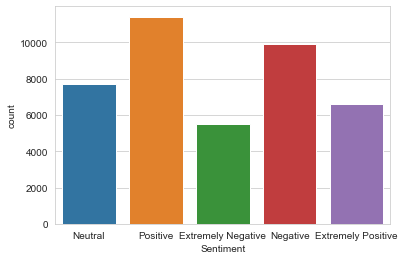

In [344]:
traingraph = pd.read_csv('input/Corona_NLP_train.csv', encoding="ISO-8859-1", low_memory=False)
y_graph = traingraph['Sentiment'].copy()
sns.set_style('whitegrid')
sns.countplot(y_graph)

In [342]:
y_graph

0                   Neutral
1                  Positive
2                  Positive
3                  Positive
4        Extremely Negative
                ...        
41152               Neutral
41153    Extremely Negative
41154              Positive
41155               Neutral
41156              Negative
Name: Sentiment, Length: 41157, dtype: object

In [5]:
#Encoding the y variable
encoding = {'Extremely Negative': 1,'Negative': 1,
            'Neutral': 0,
            'Positive':2,'Extremely Positive': 2 }
labels = ['Negative', 'Neutral', 'Positive']
y_train_valid.replace(encoding, inplace=True)

In [18]:
y_test.replace(encoding, inplace=True)

In [19]:
y_test

0       1
1       2
2       2
3       1
4       0
       ..
3793    2
3794    1
3795    0
3796    1
3797    2
Name: Sentiment, Length: 3798, dtype: int64

In [14]:
y_train_valid.value_counts()

2    18046
1    15398
0     7713
Name: Sentiment, dtype: int64

In [6]:
#Splitting the dataset
x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid, y_train_valid, 
                                                    train_size=0.75, 
                                                    random_state=33)

In [7]:
print(x_train.shape)
print(x_valid.shape)

(30867,)
(10290,)


In [19]:
print(y_train.value_counts())
print(y_valid.value_counts())

2    13585
1    11504
0     5778
Name: Sentiment, dtype: int64
2    4461
1    3894
0    1935
Name: Sentiment, dtype: int64


In [20]:
x_train[0:5]

26694    Looking to help people during the #coronavirus...
39212    I donÂt think my kid is going to be too pleas...
12131    Working from home during the outbreak As you r...
16234    Please REPORT HOARDING of Toilet Paper, Hand S...
39703    For those in need of hand sanitizer in #Chapel...
Name: OriginalTweet, dtype: object

In [8]:
#Pre-processing the text
#From: https://www.kaggle.com/himanshutripathi/covid-19-tweets-analysis-97-accuracy
stop_word = stopwords.words('english')
def clean(text):
    text = re.sub(r'http\S+', " ", text)
    text = re.sub(r'@\w+',' ',text)
    text = re.sub(r'#\w+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub('r<.*?>',' ', text)
    text = text.split()
    text = " ".join([word for word in text if not word in stop_word])
    return text

In [9]:
x_train[0:5]

26694    Looking to help people during the #coronavirus...
39212    I donÂt think my kid is going to be too pleas...
12131    Working from home during the outbreak As you r...
16234    Please REPORT HOARDING of Toilet Paper, Hand S...
39703    For those in need of hand sanitizer in #Chapel...
Name: OriginalTweet, dtype: object

In [10]:
train_clean = x_train.apply(lambda x: clean(x))
valid_clean = x_valid.apply(lambda x: clean(x))

In [137]:
#Saving the validation data to use with the BERT model (separate notebook file)
valid_clean.to_csv("valid_clean.csv")

In [20]:
#Apapted from https://www.kaggle.com/himanshutripathi/covid-19-tweets-analysis-97-accuracy
test_clean = x_test.apply(lambda x: clean(x))

In [21]:
test_clean

0       TRENDING: New Yorkers encounter empty supermar...
1       When I find hand sanitizer Fred Meyer, I turne...
2                             Find protect loved ones . ?
3       buying hits City anxious shoppers stock food&a...
4       One week everyone buying baby milk powder next...
                              ...                        
3793    Meanwhile In A Supermarket Israel -- People da...
3794    Did panic buy lot non-perishable items? ECHO n...
3795    Asst Prof Economics talking recent research co...
3796    Gov need somethings instead biar je rakyat ass...
3797    I members committed safety employees end-users...
Name: OriginalTweet, Length: 3798, dtype: object

In [11]:
train_clean[0:5]

26694    Looking help people pandemic? Support food ban...
39212    I donÂt think kid going pleased sees Easter B...
12131    Working home outbreak As getting work home sys...
16234    Please REPORT HOARDING Toilet Paper, Hand Sani...
39703    For need hand sanitizer , graciously converted...
Name: OriginalTweet, dtype: object

## RNN-based model

In [14]:
#Finding maximum length of a sequence
max_len = np.max(train_clean.apply(lambda x :len(x)))
max_len

286

In [25]:
#Apapted from https://www.kaggle.com/himanshutripathi/covid-19-tweets-analysis-97-accuracy
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_clean)
vocab_length = len(tokenizer.word_index) + 1
x_train = tokenizer.texts_to_sequences(train_clean)
x_test = tokenizer.texts_to_sequences(test_clean)
x_valid = tokenizer.texts_to_sequences(valid_clean)
x_train = pad_sequences(x_train, maxlen=max_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_len, padding='post')
x_valid = pad_sequences(x_valid, maxlen=max_len, padding='post')

In [23]:
x_train

array([[  278,    30,     8, ...,     0,     0,     0],
       [    2,   153,    92, ...,     0,     0,     0],
       [   79,    21,    70, ...,     0,     0,     0],
       ...,
       [  803, 31151,  3084, ...,     0,     0,     0],
       [  830,   139,  1865, ...,     0,     0,     0],
       [   98,    53,   257, ...,     0,     0,     0]])

In [26]:
x_valid

array([[  60,  784,  179, ...,    0,    0,    0],
       [3762, 4446, 2409, ...,    0,    0,    0],
       [ 100, 1274,   31, ...,    0,    0,    0],
       ...,
       [  37,  205,   29, ...,    0,    0,    0],
       [1178,  136,  858, ...,    0,    0,    0],
       [1098,   23,   42, ...,    0,    0,    0]])

In [24]:
x_test

array([[ 2915,    36,  4914, ...,     0,     0,     0],
       [  197,     2,   134, ...,     0,     0,     0],
       [  134,   229,  1637, ...,     0,     0,     0],
       ...,
       [ 4575,  3008,   862, ...,     0,     0,     0],
       [  933,    15, 15300, ...,     0,     0,     0],
       [    2,   715,  2409, ...,     0,     0,     0]])

In [27]:
vocab_length

31156

In [28]:
embedding_dim = 16

In [29]:
#Apapted from https://www.kaggle.com/himanshutripathi/covid-19-tweets-analysis-97-accuracy
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation='softmax')])

In [30]:
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

In [32]:
y_train = to_categorical(y_train, 3)
y_valid = to_categorical(y_valid, 3)
y_test = to_categorical(y_test, 3)

In [39]:
%%time
y_train

Wall time: 0 ns


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [36]:
#From: https://www.tensorflow.org/tutorials/keras/save_and_load
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [40]:
%%time
num_epochs = 5
history = model.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_valid, y_valid),callbacks=[cp_callback])
# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

Epoch 1/5
965/965 [==============================] - 1904s 2s/step - loss: 0.9107 - accuracy: 0.5604 - val_loss: 0.7092 - val_accuracy: 0.7129

Epoch 00001: saving model to training_1\cp.ckpt
Epoch 2/5
965/965 [==============================] - 3597s 4s/step - loss: 0.5893 - accuracy: 0.7840 - val_loss: 0.4666 - val_accuracy: 0.8345

Epoch 00002: saving model to training_1\cp.ckpt
Epoch 3/5
965/965 [==============================] - 2304s 2s/step - loss: 0.3528 - accuracy: 0.8864 - val_loss: 0.4382 - val_accuracy: 0.8452

Epoch 00003: saving model to training_1\cp.ckpt
Epoch 4/5
965/965 [==============================] - 2266s 2s/step - loss: 0.2404 - accuracy: 0.9265 - val_loss: 0.4697 - val_accuracy: 0.8499

Epoch 00004: saving model to training_1\cp.ckpt
Epoch 5/5
965/965 [==============================] - 1884s 2s/step - loss: 0.1743 - accuracy: 0.9496 - val_loss: 0.5101 - val_accuracy: 0.8498

Epoch 00005: saving model to training_1\cp.ckpt
Wall time: 3h 19min 14s


In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [45]:
os.listdir(checkpoint_dir)

['checkpoint', 'cp.ckpt.data-00000-of-00001', 'cp.ckpt.index']

In [44]:
print(f"Accuracy on training data is: {acc[-1]*100} %")
print(f"Loss {loss[-1]*100}")

print(f"Accuracy on validation data is: {val_acc[-1]*100} %")
print(f"Loss {val_loss[-1]*100}")

Accuracy on training data is: 94.95902061462402 %
Loss 17.42846965789795
Accuracy on validation data is: 84.97570753097534 %
Loss 51.00771188735962


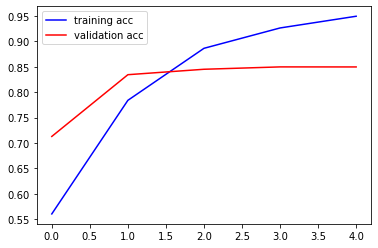

<Figure size 432x288 with 0 Axes>

In [49]:
epochs = range(len(acc))

plt.plot(epochs, acc,'b',label='training acc')
plt.plot(epochs, val_acc, 'r', label='validation acc')
plt.legend()
plt.show()
plt.savefig('accuracy.png')

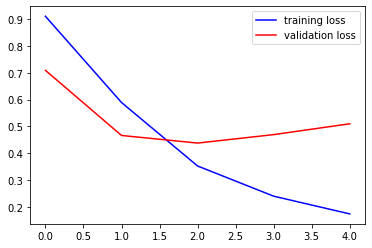

<Figure size 432x288 with 0 Axes>

In [48]:
plt.plot(epochs, loss,'b',label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.legend()
plt.show()
plt.savefig('loss.png')

In [46]:
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [55]:
%%time
pred = model.predict(x_valid)

Wall time: 1min 48s


In [57]:
pred

array([[7.4066788e-01, 1.1320856e-01, 1.4612359e-01],
       [3.0834286e-05, 1.0666232e-05, 9.9995852e-01],
       [1.8598729e-01, 6.3211167e-01, 1.8190108e-01],
       ...,
       [2.2368776e-03, 1.3542393e-03, 9.9640888e-01],
       [1.1953839e-01, 1.9977149e-01, 6.8069005e-01],
       [5.9703298e-02, 8.8069302e-01, 5.9603728e-02]], dtype=float32)

In [136]:
y_valid[0:5]

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [69]:
np.argmax(pred,1)

array([0, 2, 1, ..., 2, 2, 1], dtype=int64)

In [68]:
np.argmax(y_valid,1)

array([1, 2, 1, ..., 2, 1, 1], dtype=int64)

In [70]:
confusion_matrix(np.argmax(y_valid,1), np.argmax(pred,1))

array([[1538,  202,  195],
       [ 142, 3331,  421],
       [ 113,  473, 3875]], dtype=int64)

In [72]:
print(classification_report(np.argmax(y_valid,1), np.argmax(pred,1)))

              precision    recall  f1-score   support

           0       0.86      0.79      0.83      1935
           1       0.83      0.86      0.84      3894
           2       0.86      0.87      0.87      4461

    accuracy                           0.85     10290
   macro avg       0.85      0.84      0.84     10290
weighted avg       0.85      0.85      0.85     10290



## Traditional NLP model

In [80]:
print(train_clean[0:5])
print(valid_clean[0:5])

26694    Looking help people pandemic? Support food ban...
39212    I donÂt think kid going pleased sees Easter B...
12131    Working home outbreak As getting work home sys...
16234    Please REPORT HOARDING Toilet Paper, Hand Sani...
39703    For need hand sanitizer , graciously converted...
Name: OriginalTweet, dtype: object
24730    delivery slots available March April Harrow ar...
997      Wells Fargo committed helping customers experi...
4157     What hell going country, shops selling sanitiz...
13298    / &amp; Supermarket stockers cashiers. Pharmac...
40701    Our friends conducting ongoing research consum...
Name: OriginalTweet, dtype: object


In [76]:
#The following code was adapted from a lecture by Sarah Jane (lecturer at TUD)
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()        
count_vect  

CountVectorizer()

In [82]:
#Create the Term-Document Matrix
tdm = count_vect.fit_transform(train_clean)   
tdm.shape

(30867, 29407)

In [89]:
#Transform the TDM to a normalised tf or tf-idf matrix 
from sklearn.feature_extraction.text import TfidfTransformer
transformer_NLP = TfidfTransformer()   
transformer_NLP   

TfidfTransformer()

In [90]:
tdm_tfidf = transformer_NLP .fit_transform(tdm)   #transform the TDM
tdm_tfidf.shape

(30867, 29407)

In [91]:
y_train

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [92]:
from sklearn.ensemble import RandomForestClassifier

In [171]:
%%time
clf = RandomForestClassifier(n_estimators=40, criterion='gini', max_depth=25000, min_samples_split=3, 
                             random_state=33, verbose=0)

Wall time: 1 ms


In [172]:
%%time
clf.fit(tdm_tfidf, y_train)

Wall time: 17.3 s


RandomForestClassifier(max_depth=25000, min_samples_split=3, n_estimators=40,
                       random_state=33)

In [180]:
joblib.dump(clf, "./random_forest.joblib")

['./random_forest.joblib']

In [173]:
valid_counts = count_vect.transform(valid_clean)   
valid_tfidf = transformer_NLP.transform(valid_counts)

In [174]:
pred_NLP = clf.predict(valid_tfidf)

In [175]:
pred_NLP

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [176]:
confusion_matrix(np.argmax(y_valid,1), np.argmax(pred_NLP,1))

array([[1626,  108,  201],
       [1072, 2268,  554],
       [ 886,  342, 3233]], dtype=int64)

In [177]:
print(classification_report(np.argmax(y_valid,1), np.argmax(pred,1)))

              precision    recall  f1-score   support

           0       0.86      0.79      0.83      1935
           1       0.83      0.86      0.84      3894
           2       0.86      0.87      0.87      4461

    accuracy                           0.85     10290
   macro avg       0.85      0.84      0.84     10290
weighted avg       0.85      0.85      0.85     10290



## BERT-based model

In [154]:
resultsRoberta = pd.read_csv('results_part1.csv',header=None)

In [155]:
resultsRoberta.to_numpy().shape

(3000, 1)

In [167]:
resultsRoberta2 = resultsRoberta.to_numpy().reshape((1000,3))

In [168]:
resultsRoberta2.shape

(1000, 3)

In [185]:
#The results here are presented as probability of positive, neutral and negative (in this order)
resultsRoberta2

array([[0.01510268, 0.94126981, 0.04362738],
       [0.00871244, 0.36229369, 0.62899387],
       [0.92398417, 0.07094125, 0.00507452],
       ...,
       [0.040506  , 0.77590334, 0.18359062],
       [0.30760223, 0.62234062, 0.07005718],
       [0.64365494, 0.32021326, 0.03613192]])

In [193]:
#The results have to be swapped to the same format of the y_valid data (that is, neutral, negative and positive)
resultsRoberta3 = resultsRoberta2
resultsRoberta3[:, :2] = resultsRoberta2[:, 1::-1]
resultsRoberta3

array([[0.94126981, 0.01510268, 0.04362738],
       [0.36229369, 0.00871244, 0.62899387],
       [0.07094125, 0.92398417, 0.00507452],
       ...,
       [0.77590334, 0.040506  , 0.18359062],
       [0.62234062, 0.30760223, 0.07005718],
       [0.32021326, 0.64365494, 0.03613192]])

In [195]:
resultsRoberta3.shape

(1000, 3)

In [206]:
#Selecting only the top 1000 results
y_valid_1000 = y_valid[:1000]

In [207]:
y_valid_1000.shape

(1000, 3)

## Comparing results for all three models

In [203]:
#BERT based model
confusion_matrix(np.argmax(y_valid_1000,1), np.argmax(resultsRoberta3,1))

array([[131,  33,   8],
       [144, 200,   9],
       [275,  69, 131]], dtype=int64)

In [208]:
print(classification_report(np.argmax(y_valid_1000,1), np.argmax(resultsRoberta3,1)))

              precision    recall  f1-score   support

           0       0.24      0.76      0.36       172
           1       0.66      0.57      0.61       353
           2       0.89      0.28      0.42       475

    accuracy                           0.46      1000
   macro avg       0.60      0.53      0.46      1000
weighted avg       0.70      0.46      0.48      1000



In [211]:
#RNN based model
pred_1000 = pred[:1000]
pred_1000.shape
confusion_matrix(np.argmax(y_valid_1000,1), np.argmax(pred_1000,1))

array([[143,  19,  10],
       [ 13, 318,  22],
       [ 14,  63, 398]], dtype=int64)

In [212]:
print(classification_report(np.argmax(y_valid_1000,1), np.argmax(pred_1000,1)))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       172
           1       0.80      0.90      0.84       353
           2       0.93      0.84      0.88       475

    accuracy                           0.86      1000
   macro avg       0.85      0.86      0.85      1000
weighted avg       0.86      0.86      0.86      1000



In [213]:
#Traditional NLP
pred_NLP_1000 = pred_NLP[:1000]
confusion_matrix(np.argmax(y_valid_1000,1), np.argmax(pred_NLP_1000,1))

array([[150,   6,  16],
       [ 89, 226,  38],
       [ 84,  44, 347]], dtype=int64)

In [214]:
print(classification_report(np.argmax(y_valid_1000,1), np.argmax(pred_NLP_1000,1)))

              precision    recall  f1-score   support

           0       0.46      0.87      0.61       172
           1       0.82      0.64      0.72       353
           2       0.87      0.73      0.79       475

    accuracy                           0.72      1000
   macro avg       0.72      0.75      0.71      1000
weighted avg       0.78      0.72      0.73      1000



In [276]:
print(f'Neutral tweets in validation set {sum(np.argmax(y_valid_1000,1)==0)} ')
print(f'Negative tweets in validation set {sum(np.argmax(y_valid_1000,1)==1)} ')
print(f'Positive tweets in validation set {sum(np.argmax(y_valid_1000,1)==2)} ')
#print(f"Accuracy on validation data is: {val_acc[-1]*100} %")

Neutral tweets in validation set 172 
Negative tweets in validation set 353 
Positive tweets in validation set 475 


## Analysis of the errors of the two best performaning models

In [316]:
#Indices that were wrongly classified by RNN-based model
print(sum((np.argmax(pred_1000,1) != np.argmax(y_valid_1000,1))))
comparison1 = np.where((np.argmax(pred_1000,1) != np.argmax(y_valid_1000,1)))[0]

141


In [318]:
#Indices that were wrongly classified by RF-based model
print(sum((np.argmax(pred_NLP_1000,1) != np.argmax(y_valid_1000,1))))
comparison2 = np.where((np.argmax(pred_NLP_1000,1) != np.argmax(y_valid_1000,1)))[0]

277


In [325]:
a = 0
for i in comparison1:
    if i in comparison2:
        a = a+1
print(a)

92


In [328]:
(141-92)/141

0.3475177304964539

## Testing the RNN-based model on the test set

In [247]:
x_test

array([[ 2915,    36,  4914, ...,     0,     0,     0],
       [  197,     2,   134, ...,     0,     0,     0],
       [  134,   229,  1637, ...,     0,     0,     0],
       ...,
       [ 4575,  3008,   862, ...,     0,     0,     0],
       [  933,    15, 15300, ...,     0,     0,     0],
       [    2,   715,  2409, ...,     0,     0,     0]])

In [246]:
y_test

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [248]:
pred_test = model.predict(x_test)

In [249]:
confusion_matrix(np.argmax(y_test,1), np.argmax(pred_test,1))

array([[ 473,   79,   67],
       [  62, 1390,  181],
       [  31,  209, 1306]], dtype=int64)

In [250]:
print(classification_report(np.argmax(y_test,1), np.argmax(pred_test,1)))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80       619
           1       0.83      0.85      0.84      1633
           2       0.84      0.84      0.84      1546

    accuracy                           0.83      3798
   macro avg       0.83      0.82      0.83      3798
weighted avg       0.83      0.83      0.83      3798



Thank you!